In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,preprocessing,callbacks
import cv2

In [2]:
#df_train=pd.read_csv('emnist-balanced-train/emnist-balanced-train.csv')
#df_test=pd.read_csv('emnist-balanced-test/emnist-balanced-test.csv')
df_train=pd.read_csv('dataset/emnist-byclass-train/emnist-byclass-train.csv')
df_test=pd.read_csv('dataset/emnist-byclass-test/emnist-byclass-test.csv')

In [3]:
mapping={}
cap_alphabet="abcdefghijklmnopqrstuvwxyz".upper()
lower_alphabet='abcdefghijklmnopqrstuvwxyz'
for i in range(10):
    mapping[i]=i
for number,c in enumerate(cap_alphabet):
    mapping[number+10]=c
for number,c in enumerate(lower_alphabet):
    mapping[number+36]=c

(28, 28)
(28, 28, 1)


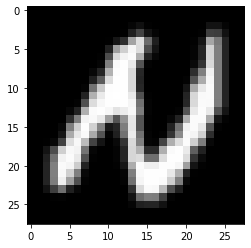

In [4]:

row=100000
temp_img=(cv2.flip(cv2.rotate(np.array(df_train.iloc[row,1:]).reshape((28,28,1)),cv2.ROTATE_90_CLOCKWISE),1))
print(temp_img.shape)
temp_img=temp_img.reshape((28,28,1))
plt.imshow(temp_img,cmap='gray')
print(temp_img.shape)
plt.show()

In [5]:

df_train_labels=df_train.iloc[:,0]
df_test_labels=df_test.iloc[:,0]
train_labels_enc=tf.keras.utils.to_categorical(df_train_labels)
test_labels_enc=tf.keras.utils.to_categorical(df_test_labels)

In [6]:
mapping={}
cap_alphabet="abcdefghijklmnopqrstuvwxyz".upper()
lower_alphabet='abcdefghijklmnopqrstuvwxyz'
for i in range(10):
    mapping[i]=i
for number,c in enumerate(cap_alphabet):
    mapping[number+10]=c
for number,c in enumerate(lower_alphabet):
    mapping[number+36]=c

In [7]:
train_mat=[]
for index,row in df_train.iterrows():
    row=cv2.flip(cv2.rotate(np.array(df_train.iloc[index,1:]).reshape((28,28,1)),cv2.ROTATE_90_CLOCKWISE),1)
    row=row.reshape((28,28,1))
    train_mat.append(row)
test_mat=[]
for index,row in df_test.iterrows():
    row=cv2.flip(cv2.rotate(np.array(df_test.iloc[index,1:]).reshape((28, 28,1)),cv2.ROTATE_90_CLOCKWISE),1)
    row=row.reshape((28,28,1))
    test_mat.append(row)
train_mat=np.array(train_mat).astype('float32')/255.0
test_mat=np.array(test_mat).astype('float32')/255.0

In [8]:
test_size=93057

In [9]:

print(train_mat.shape)
print(test_mat.shape)

(697931, 28, 28, 1)
(116322, 28, 28, 1)


In [16]:
datagen = preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    brightness_range=(30,100),
    zoom_range=(0,30),
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

In [10]:
callback=callbacks.EarlyStopping(monitor='loss',patience=2)

In [11]:
model=keras.Sequential([
    # First Convolutional Block
    layers.Conv2D(filters=128, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[28, 28, 1]
                  ),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=128, kernel_size=5, activation="relu", padding='same',
                  ),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=100, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    # Second Convolutional Block
    layers.Conv2D(filters=100, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=80, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=80, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(padding='same'),
    # Third Convolutional Block
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=1024, activation="relu"),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.05),
    layers.BatchNormalization(),
    layers.Dense(units=62, activation="softmax"),
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 100)         115300    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 100)        0

In [12]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
datagen.fit(train_mat)

NameError: name 'datagen' is not defined

In [12]:
len(train_mat)/32

21810.34375

In [13]:
len(train_mat)/100*2

13958.62

In [42]:
model.fit(datagen.flow(train_mat, train_labels_enc, batch_size=32,
                       subset='training'),
          validation_data=datagen.flow(test_mat, test_labels_enc,
                                       batch_size=32, subset='validation'),
          steps_per_epoch=len(train_mat) / 100, epochs=3,
          callbacks=[callback])


Epoch 1/3
  73/6979 [..............................] - ETA: 11:54 - loss: 4.7720 - categorical_accuracy: 0.0158

KeyboardInterrupt: 

In [44]:

history = model.fit(
    train_mat,
    train_labels_enc,
    validation_data=(test_mat[:test_size],test_labels_enc[:test_size]),
    batch_size=64,
    epochs=1
)


  805/10906 [=>............................] - ETA: 28:41 - loss: 3.9021 - accuracy: 0.0855

KeyboardInterrupt: 

In [20]:
val_loss,val_acc=model.evaluate(x=test_mat[test_size:],y=test_labels_enc[test_size:])

728/728 [==============================] - 12s 17ms/step - loss: 0.4364 - categorical_accuracy: 0.8463


In [21]:
predictions = model.predict(test_mat)

3636/3636 [==============================] - 63s 17ms/step


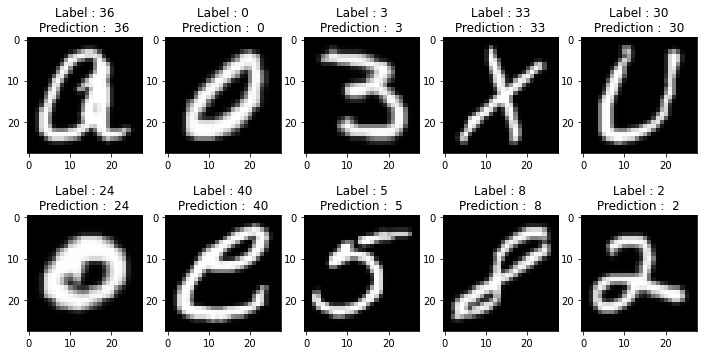

In [22]:
x_val__ = test_mat.reshape(test_mat.shape[0], 28, 28)
fig, axis = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axis.flat):
    ax.imshow(test_mat[i], cmap='gray')
    ax.set(title = f"Label : {df_test_labels[i]}\nPrediction :  {predictions[i].argmax()}")

In [23]:
model.save('saved_model/model')

INFO:tensorflow:Assets written to: saved_model/model\assets


INFO:tensorflow:Assets written to: saved_model/model\assets
